In [2]:
# get all imports out of the way
import tensorneat as tn
import jax.numpy as jnp
import pandas as pd

In [19]:
# drop nans split by symbol and join on date
file_path = "hist_data/stocks/sp500_stocks.csv"  # Update this path if needed
df = pd.read_csv(file_path)

df = df.dropna()

symbols = df['Symbol'].unique()
symbol_dfs = {symbol: df[df['Symbol'] == symbol] for symbol in symbols}

merged_df = symbol_dfs[symbols[0]].set_index('Date')

for symbol in symbols[1:]:
    symbol_data = symbol_dfs[symbol].set_index('Date')
    if (len(symbol_data) == 3768):
        merged_df = merged_df.join(symbol_data, how='inner', rsuffix=f"_{symbol}")

tensorneat_input = merged_df.to_numpy()

print(tensorneat_input.shape)

(3768, 1050)


In [20]:
print(merged_df.head())

           Symbol  Adj Close     Close      High       Low      Open  \
Date                                                                   
2010-01-04    AOS   5.937266  7.435000  7.480000  7.261667  7.295000   
2010-01-05    AOS   5.861404  7.340000  7.431667  7.308333  7.431667   
2010-01-06    AOS   5.864068  7.343333  7.405000  7.301667  7.335000   
2010-01-07    AOS   5.881369  7.365000  7.425000  7.311667  7.356667   
2010-01-08    AOS   5.967879  7.473333  7.485000  7.311667  7.331667   

               Volume Symbol_ABT  Adj Close_ABT  Close_ABT  ...    Low_WMB  \
Date                                                        ...              
2010-01-04  1104600.0        ABT      18.763718  26.129908  ...  17.445280   
2010-01-05  1207200.0        ABT      18.612118  25.918797  ...  17.534952   
2010-01-06   663000.0        ABT      18.715481  26.062737  ...  17.771360   
2010-01-07   564000.0        ABT      18.870522  26.278646  ...  18.072985   
2010-01-08   504600.0      

In [34]:
# create a target array

close_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Close']

# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = merged_df[close_columns].pct_change().shift(-1).values[:-1,:]
features = merged_df[close_columns].pct_change().values[1:,:]
print(target.shape)

print(jnp.argmax(target, axis=1).shape)

(3767, 150)
(3767,)


In [35]:
import jax.numpy as jnp
train_test_split = 0.8

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")


Sample Count: 3767
Train Size: 3013
Shape of INPUTS: (3013, 150)
Shape of RETURNS: (3013, 150)


In [40]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblem(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)
      
      # Find the index of the maximum output for each day
      selected_indices = jnp.argmax(actions, axis=1)
      
      # Calculate the reward based on the selected index
      reward = jnp.take_along_axis(RETURNS, selected_indices[:, None], axis=1).squeeze()
      
      # Return the mean reward
      return jnp.mean(reward)

  def show(self, state, randkey, act_func, params, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      selected_indices = jnp.argmax(actions, axis=1)

      # Move data to host numpy
      from jax import device_get
      import numpy as np
      selected_indices_np = np.asarray(device_get(selected_indices)).ravel()
      returns_np = np.asarray(device_get(TEST_RETURNS))

      # Ensure indices are within bounds
      num_columns = returns_np.shape[1]
      selected_indices_np = np.clip(selected_indices_np, 0, num_columns - 1)

      # Calculate performance based on selected indices
      perf = 100.0
      perf_hist = []
      for i in range(len(selected_indices_np)):
          selected_return = returns_np[i, selected_indices_np[i]]
          perf += perf * float(selected_return)
          perf_hist.append(float(perf))

      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblem()



In [41]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblemTopK(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params, k=5):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)
      
      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)
      
      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)
      
      # Gather the rewards for the top-k indices
      rewards = jnp.take_along_axis(RETURNS, topk_indices, axis=1)
      
      # Calculate the weighted reward
      weighted_rewards = jnp.sum(softmax_weights * rewards, axis=1)
      
      # Return the mean reward
      return jnp.mean(weighted_rewards)

  def show(self, state, randkey, act_func, params, k=5, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      
      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)
      
      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)
      
      # Move data to host numpy
      from jax import device_get
      import numpy as np
      topk_indices_np = np.asarray(device_get(topk_indices))
      softmax_weights_np = np.asarray(device_get(softmax_weights))
      returns_np = np.asarray(device_get(TEST_RETURNS))
      
      # Calculate performance based on top-k weighted rewards
      perf = 100.0
      perf_hist = []
      for i in range(len(topk_indices_np)):
          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[i]]
          
          # Calculate the weighted reward
          weighted_reward = np.sum(softmax_weights_np[i] * rewards)
          
          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))
      
      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblemTopK()



save to ./model_archive/tensorneat_checkpoints
initializing
initializing finished
start compile
compile finished, cost time: 3.163414s
Generation: 1, Cost time: 70998.49ms
 	fitness: valid cnt: 144, max: 0.0028, min: -0.0033, mean: 0.0007, std: 0.0007

	node counts: max: 304, min: 302, mean: 303.04
 	conn counts: max: 902, min: 599, mean: 877.22
 	species: 1, [144]

Generation: 2, Cost time: 67991.72ms
 	fitness: valid cnt: 144, max: 0.0036, min: -0.0007, mean: 0.0010, std: 0.0007

	node counts: max: 304, min: 301, mean: 302.89
 	conn counts: max: 902, min: 300, mean: 822.99
 	species: 1, [144]

Generation: 3, Cost time: 67761.98ms
 	fitness: valid cnt: 144, max: 0.0053, min: -0.0022, mean: 0.0016, std: 0.0010

	node counts: max: 304, min: 301, mean: 302.80
 	conn counts: max: 902, min: 299, mean: 812.56
 	species: 1, [144]

Generation: 4, Cost time: 75806.02ms
 	fitness: valid cnt: 144, max: 0.0054, min: -0.0013, mean: 0.0017, std: 0.0012

	node counts: max: 304, min: 301, mean: 302.9

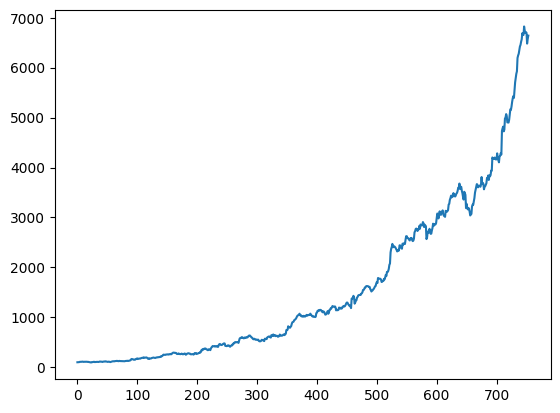

In [43]:
from tensorneat.pipeline import Pipeline
from tensorneat.algorithm.neat import NEAT
from tensorneat.genome import DefaultGenome, BiasNode, DefaultConn, DefaultMutation
from tensorneat.problem.func_fit import CustomFuncFit
from tensorneat.common import ACT, AGG
from tensorneat import algorithm

# Construct the pipeline and run
pipeline = Pipeline(
    algorithm=NEAT(
        pop_size=144,
        species_size=8,
        survival_threshold=0.1,
        compatibility_threshold=0.8,
        genome=DefaultGenome(
            max_nodes=500,
            max_conns=1500,
            num_inputs=features.shape[1],
            num_outputs=target.shape[1],
            init_hidden_layers=(3,),
            node_gene=BiasNode(
                bias_init_std=0.1,
                bias_mutate_power=0.05,
                bias_mutate_rate=0.01,
                bias_replace_rate=0.0,
                activation_options=ACT.tanh,
                aggregation_options=AGG.sum,
            ),
            conn_gene=DefaultConn(
                weight_init_mean=0.0,
                weight_init_std=0.1,
                weight_mutate_power=0.05,
                weight_replace_rate=0.0,
                weight_mutate_rate=0.001,
            ),
            output_transform=ACT.tanh,
        ),
    ),
    problem=TradingProblem(),
    generation_limit=42,
    fitness_target=.01,
    seed=42,
    is_save=True,
    save_dir="./model_archive/tensorneat_checkpoints"
)

# initialize state
state = pipeline.setup()
# run until terminate
state, best = pipeline.auto_run(state)
# show result
pipeline.show(state, best)
state.save("./model_archive/tensorneat_checkpoints/evolving_state.pkl")